## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import random
random.seed(42)
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kurtosis
from pmdarima.arima import auto_arima


In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
# from utils import eval_metrics

## Reading Data

In [4]:
sales = pd.read_csv('Dataset/train.csv')
sales.Date = pd.to_datetime(sales.Date)
sales.reset_index()
sales['Date'] = sales['Date'].astype('datetime64')
sales.set_index('Date', inplace=True)
sales = sales.sort_index(ascending=True)
sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1


# Baseline Model
1. This takes the data and calculates the Rolling mean with the given 'window'.
2. predict_timeframe set to greater than 0 (predict_timeframe >0), If there is a prediction to be made for future date. 
3. The forecast window is determined by predict timeframe

In [13]:
# Requirement : Index must be sorted in ascending order
def BaselinePrediction(data, predict_timeframe= 42, window = 12):
    timeframe_predictions = None
    plt.figure(figsize=(10,10))
    if(predict_timeframe > 0):
        val = pd.date_range(data.index[-1] + pd.Timedelta(days = 1), periods= predict_timeframe, freq= 'D')
        pred_values = list(data.iloc[-window:].values)
        for i in np.arange(1,predict_timeframe):
            pred_values.append(np.sum(pred_values[-window:])/window)
        timeframe_predictions = pd.Series(index= val, data= pred_values[-predict_timeframe:]) 
        timeframe_predictions.fillna(0,inplace=True)   
        plt.plot(timeframe_predictions, color = 'red', label= "Test Predictions")   
    predictions = data.rolling(window).mean()
    predictions.fillna(0, inplace = True)
    plt.plot(data,color = '#000000', label = 'Original Data')
    plt.plot(predictions[window:], color = 'green', label = 'Train Predictions')
    plt.legend()
    return timeframe_predictions

In [14]:
def eval_metrics(actual_val, predicted_val):
    """
    Returns the MSE, MAE and RMSE Error for the given values
    Parameters:
    * actual_val    : The actual value of the data
    * predicted_val : The predicted value of the data
    returns:
    errors<Tuple> : A tuple of MSE MAE and RMSE score for the data (MSE, MAE, RMSE)
    """
    mse     = (np.square(actual_val - predicted_val)).mean()
    mae     = (np.abs(actual_val - predicted_val)).mean()
    rmse    = np.sqrt(mse)
    errors  = (mse,mae,rmse)
    return errors

def print_eval_metrics(actual_val, predicted_val):
    mse,mae,rmse = eval_metrics(actual_val, predicted_val)
    print(f"\nThe Mean Squared Error(MSE) : {mse}")
    print(f"\nThe Mean Absolute Error(MAE) : {mae}")
    print(f"\nThe Root Mean Squared Error(RMSE) : {rmse}")

# Predictions


### For Store Number(1)

In [15]:
print(random.randint(1, 1555))
first_store = sales[sales['Store'] == 1]
first_store_open = first_store[first_store.Open ==1]
# first_store.index= first_store.index.astype('datetime64[ns]')
fs = first_store.Sales.copy()
fs_open = first_store_open.Sales.copy()
fs.sort_index(ascending= True, inplace= True)
fs_open.sort_index(ascending= True, inplace=True)

52


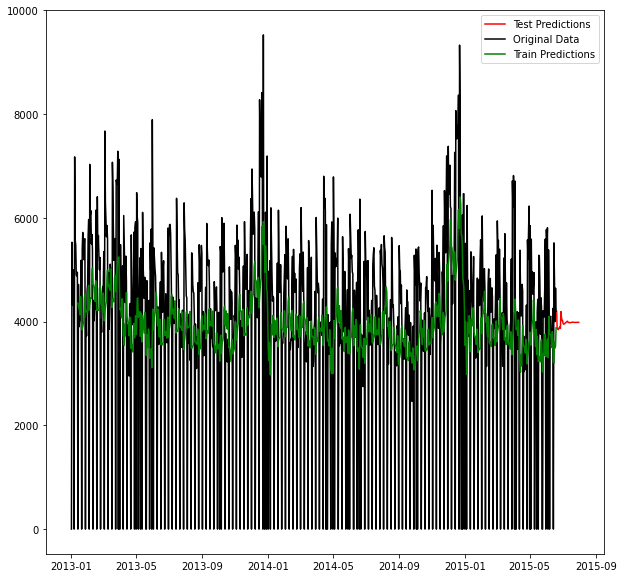

In [17]:
predict_timeframe = 42
window = 12
data = fs
# plt.figure(figsize=(20,10))
predict_1 = BaselinePrediction(fs[:-42], predict_timeframe=predict_timeframe, window=window)
# plt.plot(fs)

In [22]:
print_eval_metrics(predict_1, fs[-42:])


The Mean Squared Error(MSE) : 2869023.855084995

The Mean Absolute Error(MAE) : 1137.8353478616295

The Root Mean Squared Error(RMSE) : 1693.8193100460849


In [28]:
fs[-42:]

Date
2015-06-20    4097
2015-06-21       0
2015-06-22    3846
2015-06-23    3762
2015-06-24    3346
2015-06-25    3533
2015-06-26    3317
2015-06-27    4019
2015-06-28       0
2015-06-29    5197
2015-06-30    5735
2015-07-01    5223
2015-07-02    5558
2015-07-03    4665
2015-07-04    4797
2015-07-05       0
2015-07-06    4359
2015-07-07    3650
2015-07-08    3797
2015-07-09    3897
2015-07-10    3808
2015-07-11    3530
2015-07-12       0
2015-07-13    5054
2015-07-14    5042
2015-07-15    4767
2015-07-16    4427
2015-07-17    4852
2015-07-18    4406
2015-07-19       0
2015-07-20    4395
2015-07-21    3558
2015-07-22    3464
2015-07-23    3769
2015-07-24    3706
2015-07-25    4364
2015-07-26       0
2015-07-27    6102
2015-07-28    5011
2015-07-29    4782
2015-07-30    5020
2015-07-31    5263
Name: Sales, dtype: int64

### Taking the Mean of the data as the baseline model

In [ ]:
def SimpleMeanBaseline(data, title= "hello" ,  mean_line = True, xlabel="time", ylabel="series"):
    plt.figure(figsize =(10 ,7))

    predictions = pd.Series([ np.nanmean(data) ]* len(fs) , index = fs.index)   
    plt.plot(data)
    if(mean_line  == True):
        plt.axhline(y=np.nanmean(data), color = "red", label = f'mean(= {np.nanmean(data):.2f} )')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=45 , rotation_mode='anchor', ha ='right' )
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show();
    return predictions

In [ ]:
meanbase_pred = SimpleMeanBaseline(fs_open)

In [ ]:
eval_metrics(meanbase_pred, fs_open)

# For Store with maximum/minimum Sales

In [ ]:
sales_sum_store = sales.groupby('Store')['Sales'].mean()

In [ ]:
store_w_max_sales = sales_sum_store.argmax()
store_w_min_sales = sales_sum_store.argmin()


In [ ]:
df_max_sales = sales[sales.Store == store_w_max_sales]
df_min_sales = sales[sales.Store == store_w_min_sales]
df_max_sales_open = df_max_sales[df_max_sales.Open == 1]
df_min_sales_open = df_min_sales[df_min_sales.Open == 1]

In [ ]:
store_highest =BaselinePrediction(df_max_sales_open.Sales)

In [ ]:
print_eval_metrics(store_highest, df_max_sales_open.Sales)

In [ ]:
store_lowest = BaselinePrediction(df_min_sales_open.Sales)

In [ ]:
mask = (df_min_sales_open.index > '2014-07') & (df_min_sales_open.index<'2015-02')
df_min_sales_open[mask]